# NLP intent classifier : emotions/sentiments analysis on MELD dataset

SHEVCHUK Anna, TAVERNIER Léo – ENSAE 2022-2023

### Useful libraries

In [1]:
#pip install transformers

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tnrange
import re
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.probability import FreqDist

from textblob import TextBlob

from wordcloud import WordCloud

from transformers import BertTokenizer, AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Data loading and analysis

In [3]:
url = 'https://raw.githubusercontent.com/declare-lab/MELD/master/data/MELD/train_sent_emo.csv'
data = pd.read_csv(url, index_col=0)
emotions = data.Emotion.unique().tolist() # There are 7 different emotions

labelencoder = LabelEncoder()
data['Emotion_encoded'] = labelencoder.fit_transform(data['Emotion'])
data['Sentiment_encoded'] = labelencoder.fit_transform(data['Sentiment'])
data.tail()

,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime,Emotion_encoded,Sentiment_encoded
Sr No.,,,,,,,,,,,,
10474,You or me?,Chandler,neutral,neutral,1038,13,2,3,"00:00:48,173","00:00:50,799",4,1
10475,"I got it. Uh, Joey, women don't have Adam's ap...",Ross,neutral,neutral,1038,14,2,3,"00:00:51,009","00:00:53,594",4,1
10476,"You guys are messing with me, right?",Joey,surprise,positive,1038,15,2,3,"00:01:00,518","00:01:03,520",6,2
10477,Yeah.,All,neutral,neutral,1038,16,2,3,"00:01:05,398","00:01:07,274",4,1
10478,"That was a good one. For a second there, I was...",Joey,joy,positive,1038,17,2,3,"00:01:08,401","00:01:12,071",3,2


In [4]:
# Function aiming at removing stopwords (i.e., words that are not very informative as well as highly present in the English language)
def remove_stopwords(row):
    stop_words = set(stopwords.words('english'))
    words = row.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Function that removes (part of) the apostrophes, highly presented in the corpus, but we assume them not to be a key information as the corpus is a spoken language one
def remove_quotes(df,column_name):
    for i in range(len(df)):
        df[column_name].iloc[i] = "".join(a for a in df[column_name].iloc[i] if a not in "\'")
        y = ""
        x = df[column_name].iloc[i]
        for j in x:
            if(j not in "’"):
                y = y + j
        df[column_name].iloc[i] = y

# Function that counts words in utterances (without taking spaces/blanks into account)
def count_words(text):
    words = re.findall(r'\w+', text)
    return len(words)

In [5]:
pd.set_option('mode.chained_assignment', None)
data['Utterance'] = data['Utterance'].apply(remove_stopwords)
remove_quotes(data,'Utterance')
data['Words_count'] = data['Utterance'].apply(count_words)

# Filtering out rows such as Words_count is smaller than 3, assuming that utterances with less than 3 words convey poor information when it comes to detecting
# a speaker's emotion and add noise to the data, thus negatively affecting the model's ability to accuratly disentangle the underlying pattern of the data
data = data[data['Words_count'] >= 3]

# Creating a polarity score foe each utterance, where -1 is associated to the most negative sentences and 1 to the most positive ones (interesting to see whether it matches the emotion labels)
data['Polarity_Score'] = data['Utterance'].apply(lambda x: TextBlob(x).sentiment.polarity)

By pre-processing the dataset as above, 3146 utterances have been remooved, thus going from a grand total of 9989 to 6843.

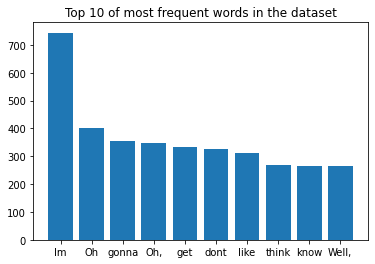

In [6]:
# Checking the most frequent words in the data
data_split = data.Utterance.str.split(expand=True).stack().value_counts().reset_index()
data_split.columns = ['Word', 'Frequency'] 
 
word_distrib = data_split.iloc[0:10] # top 10 of most frequent words
plt.bar(word_distrib['Word'], word_distrib['Frequency'])
plt.title('Top 10 of most frequent words in the dataset')
plt.show()

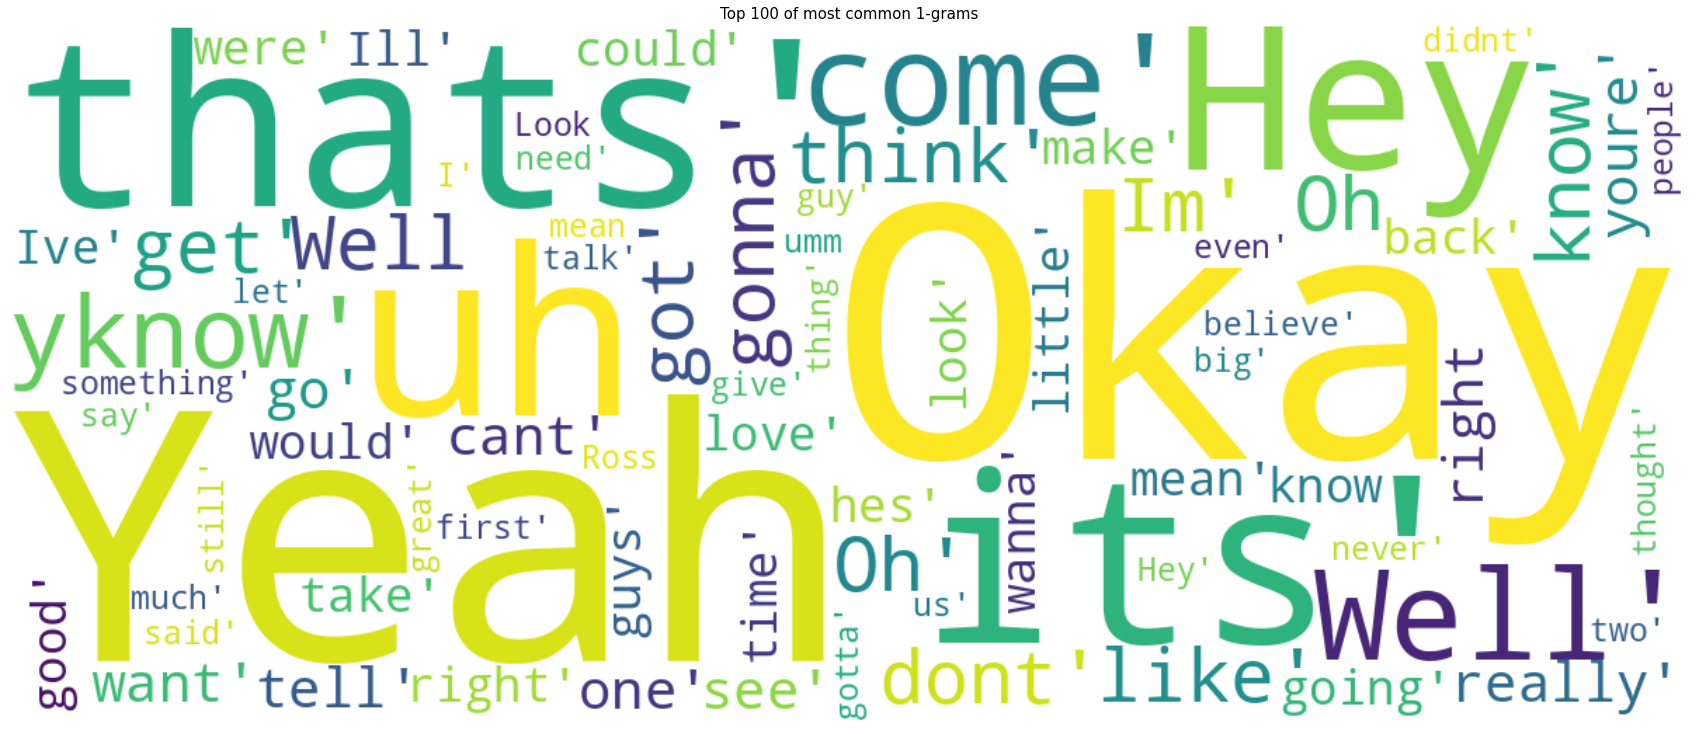

In [7]:
# Designing a word cloud that represents the most frequent 1-grams (words) in our corpus, where the size of each word represents its frequency
allwords = ' '.join(data['Utterance']).split()
mostcommon = FreqDist(allwords).most_common(100)
wordcloud = WordCloud(width=1200, height=500, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 of most common 1-grams', fontsize=15)
plt.tight_layout(pad=0)
plt.show()

In [8]:
# Descriptive statistics on the 'clean' dataset
df = np.zeros((9,7))
metrics = ['Max', '75th', 'Median', 'Avg', "25th", 'Min', "StDev", 'Words count', '# Utt.']

i = 0
for emotion in emotions:
    df[0,i] = data.loc[data['Emotion'] == emotion].groupby('Emotion')['Words_count'].max()
    df[1,i] = data.loc[data['Emotion'] == emotion].groupby('Emotion')['Words_count'].quantile(0.75)
    df[2,i] = data.loc[data['Emotion'] == emotion].groupby('Emotion')['Words_count'].median()
    df[3,i] = data.loc[data['Emotion'] == emotion].groupby('Emotion')['Words_count'].mean()
    df[4,i] = data.loc[data['Emotion'] == emotion].groupby('Emotion')['Words_count'].quantile(0.25)
    df[5,i] = data.loc[data['Emotion'] == emotion].groupby('Emotion')['Words_count'].min()
    df[6,i]= data.loc[data['Emotion'] == emotion].groupby('Emotion')['Words_count'].std()
    df[7,i]= data.loc[data['Emotion'] == emotion].groupby('Emotion')['Words_count'].sum()
    df[8,i]= data.loc[data['Emotion'] == emotion].groupby('Emotion')['Utterance_ID'].count()
    i+=1

stats_des = pd.DataFrame(df, columns=emotions, index=metrics)
stats_des = stats_des.astype('int')
print(stats_des.head(9))

# Printing in LaTeX format, for the final report
print('-------------------------------------------------------------------------------------')
print(stats_des.to_latex(index = True)) 

             neutral  surprise  fear  sadness   joy  disgust  anger
Max               30        17    17       40    23       19     22
75th               8         7     9        8     8        9      9
Median             5         5     6        6     6        7      6
Avg                6         5     6        6     6        7      6
25th               4         3     4        4     4        4      4
Min                3         3     3        3     3        3      3
StDev              3         2     3        3     3        3      3
Words count    19725      3743  1476     3813  7845     1477   5530
# Utt.          3149       660   217      560  1217      206    834
-------------------------------------------------------------------------------------
\begin{tabular}{lrrrrrrr}
\toprule
{} &  neutral &  surprise &  fear &  sadness &   joy &  disgust &  anger \\
\midrule
Max         &       30 &        17 &    17 &       40 &    23 &       19 &     22 \\
75th        &        8 &     

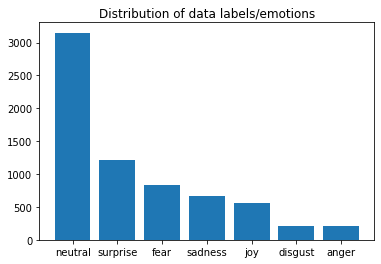

In [9]:
# Checking the distribution of data labels ('Emotion' column)
emot = data.Emotion.value_counts().reset_index()
emot.columns = ['Emotion', 'Frequency'] 

plt.bar(emotions, emot['Frequency'])
plt.title('Distribution of data labels/emotions')
plt.show()

It is worth highlighting that the data are highly skewed towards the neutral and surprise sentiments (much more towards the first one).

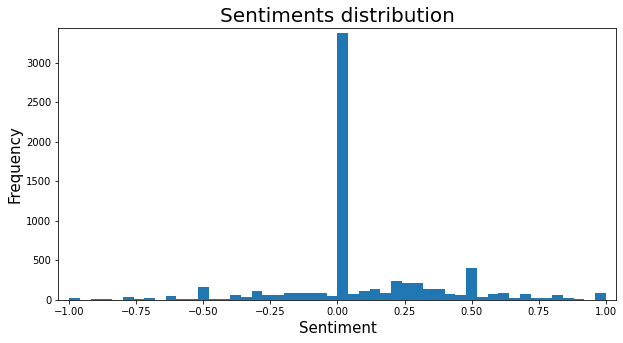

In [10]:
# Ploting the sentiment distribution using the polarity score previously calculated
plt.figure(figsize=(10,5))
plt.margins(0.02)
plt.xlabel('Sentiment', fontsize=15)
plt.xticks(fontsize=10)
plt.ylabel('Frequency', fontsize=15)
plt.yticks(fontsize=10)
plt.hist(data['Polarity_Score'], bins=50)
plt.title('Sentiments distribution', fontsize=20)
plt.show()

We can notice that the polarity score calculated rather matches the overall distribution of emotions and sentiments within the dataset, as the distribution is centered around zero, which precisely corresponds to the 'neutral' emotion/sentiment.

<Axes: >

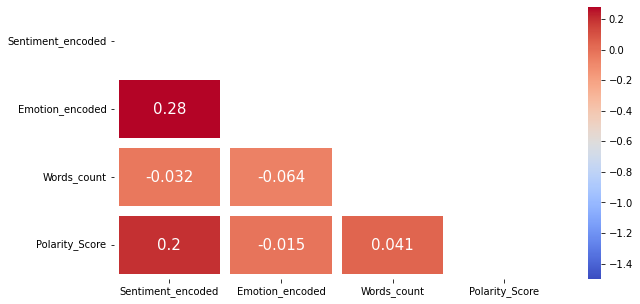

In [11]:
# Correlation matrix between all numerical variables : 'Emotion', 'Sentiment', 'Words_count' and 'Polarity_Score' columns
correlation = data[['Sentiment_encoded','Emotion_encoded', 'Words_count','Polarity_Score']].corr()
mask = np.zeros_like(correlation, dtype = bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10,5))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
sns.heatmap(correlation, cmap='coolwarm', annot=True, annot_kws={'size': 15}, linewidths=10, vmin=-1.5, mask=mask)


*   We see above that the polarity score is positively correlated with the 
sentiment, which appears meaningful as it is precisely what the polarity score measures
*   Emotions and sentiments are positively correlated as well, which also appears reasonable as these concepts are relatively entangled
*   A contrario and rather surprisingly, words count is sightly negatively correlated with both the emotion and the sentiment

### Model setting

In [12]:
utterances = data['Utterance'].values
max_len = 256

# BERT tokenizer to convert utterances into word embeddings 
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)
inputs = [tokenizer.encode(words, add_special_tokens=True, max_length = max_len, pad_to_max_length=True) for words in utterances]
labels = data['Emotion_encoded'].values

# Attention mask creation
attention_masks = []
# Mask of 1 for all input tokens and 0 for all padding tokens
attention_masks = [[float(i>0) for i in seq] for seq in inputs]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


#### Train and test sets definition

In [13]:
# Splitting the data into train and test sets
train_inputs,validation_inputs,train_labels,validation_labels = train_test_split(inputs, labels, random_state=41, test_size=0.3)
train_masks,validation_masks,_,_ = train_test_split(attention_masks, inputs, random_state=41, test_size=0.3)

In [14]:
# Converting all the data into torch tensors, required to implement the NN
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Batch size for training
batch_size = 16 # for BERT fine-tuning, the literature recommends a batch size of 16 or 32

# Creation of an iterator of the data with torch DataLoader
# It helps saving memory during training – unlike a loop – as the entire dataset does not need to be loaded into memory
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = RandomSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

#### Model definition

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=7).to(device)

# Setting values for hyperpameters and the number of training epochs, according to the existing literature
lr = 2e-5
adam_epsilon = 1e-8
epochs = 10

# AdamW optimizer and PyTorch scheduler
num_warmup_steps = 0
num_training_steps = len(train_dataloader)*epochs

optimizer = AdamW(model.parameters(), lr=lr, eps=adam_epsilon, correct_bias=False) 
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

### Training phase

In [16]:
def training_phase(model, epochs, train_dataloader, optimizer, scheduler):
    train_loss_set = []

    model.zero_grad() # Gradients are cumulated by default

    for _ in tnrange(1, epochs+1, desc='Epoch'): # tnrange is a tqdm wrapper around the 'basic' Python range
        print("<" + "="*22 + F" Epoch {_} "+ "="*22 + ">")

        # Loss computation for each epoch
        batch_loss = 0
        for step, batch in enumerate(train_dataloader):
            # Setting the model to training mode (as opposed to evaluation mode)
            model.train()
            
             # Adding batch to GPU
            batch = tuple(t.to(device) for t in batch)

            # Unpacking the inputs from the dataloader
            b_input_ids, b_input_mask, b_labels = batch

            # Forward pass
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs[0]
            
            # Backward pass
            loss.backward()
            
            # Cliping the norm of the gradients to 1.0
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Gradient clipping is not in AdamW anymore
            
            # Updating parameters and taking a step using the computed gradient
            optimizer.step()
            
            # Updating the learning rate scheduler
            scheduler.step()

            # Clearing the previously accumulated gradients
            optimizer.zero_grad()
            
            # Updating the tracking variable
            batch_loss += loss.item()

        # Computing the average loss over the training data
        avg_train_loss = batch_loss / len(train_dataloader)

        # Storing the current learning rate
        for param_group in optimizer.param_groups:
            train_loss_set.append(avg_train_loss)
    
        print(F'\n\tAverage Training Loss: {avg_train_loss}')

    return train_loss_set

In [17]:
# Function that plots the train loss
def train_loss_plot(epochs, train_loss_set):
    x = [i+1 for i in range(epochs)]
    plt.plot(x, train_loss_set)
    plt.title('Training loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.xticks(range(1,epochs))
    plt.show()

<ipython-input-16-0ee8bb96e1c9>:6: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for _ in tnrange(1, epochs+1, desc='Epoch'): # tnrange is a tqdm wrapper around the 'basic' Python range


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

<====================== Epoch 1 ======================>

	Average Training Loss: 1.3678266070286433
<====================== Epoch 2 ======================>

	Average Training Loss: 1.0948699006438256
<====================== Epoch 3 ======================>

	Average Training Loss: 0.7903320333858331
<====================== Epoch 4 ======================>

	Average Training Loss: 0.5200015584627787
<====================== Epoch 5 ======================>

	Average Training Loss: 0.3342890703243514
<====================== Epoch 6 ======================>

	Average Training Loss: 0.2128556390851736
<====================== Epoch 7 ======================>

	Average Training Loss: 0.13652856118045748
<====================== Epoch 8 ======================>

	Average Training Loss: 0.10355604214593768
<====================== Epoch 9 ======================>

	Average Training Loss: 0.0700237723463215
<====================== Epoch 10 ======================>

	Average Training Loss: 0.05331408243160

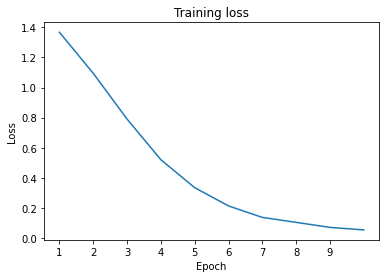

In [18]:
train_loss_set = training_phase(model, epochs, train_dataloader, optimizer, scheduler)
train_loss_plot(epochs, train_loss_set)

### Testing phase

In [19]:
def testing_phase(model, validation_dataloader):
    model.eval()
    df_metrics = pd.DataFrame(columns=['Actual_class','Predicted_class']) # DataFrame of true and predicted labels

    # Evaluation for one epoch
    for batch in validation_dataloader:
        # Adding batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpacking the inputs from the dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients, thus saving memory and speeding up validation
        with torch.no_grad():
            logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask) # Forward pass and logit predictions computation
    
        # Moving logits and labels to CPU
        logits = logits[0].to('cpu').numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Predicting labels and filling df_metrics 
        pred_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()
        df_metrics_temp = pd.DataFrame({'Actual_class': labels_flat,'Predicted_class': pred_flat})
        df_metrics = pd.concat([df_metrics, df_metrics_temp],ignore_index=True)

    return df_metrics

In [20]:
df_metrics = testing_phase(model, validation_dataloader)

### Overall statistics and confusion matrix

In [21]:
print(classification_report(df_metrics['Actual_class'].values.astype(int), df_metrics['Predicted_class'].values.astype(int), digits=7))

              precision    recall  f1-score   support

           0  0.3755869 0.3347280 0.3539823       239
           1  0.1875000 0.2000000 0.1935484        60
           2  0.1818182 0.1587302 0.1694915        63
           3  0.4303483 0.4528796 0.4413265       382
           4  0.6981328 0.7106653 0.7043433       947
           5  0.2209302 0.2420382 0.2310030       157
           6  0.4918033 0.4390244 0.4639175       205

    accuracy                      0.5241111      2053
   macro avg  0.3694457 0.3625808 0.3653732      2053
weighted avg  0.5228935 0.5241111 0.5230702      2053



In [22]:
def display_conf_matrix(df_metrics):
    cm = confusion_matrix(df_metrics['Actual_class'].values.astype(int), df_metrics['Predicted_class'].values.astype(int))
    display = ConfusionMatrixDisplay(cm)
    display.plot()
    display.ax_.set_title("Confusion matrix of the classifier")
    plt.show()

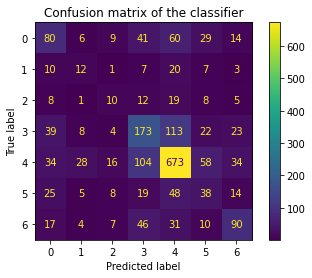

In [23]:
display_conf_matrix(df_metrics) # As a reminder, 'anger': 0 – 'disgust' : 1 – 'fear' : 2 – 'joy' : 3 – 'neutral' : 4 – 'sadness' : 5 – 'surprise' : 6

### Applying the model to the sentiments, i.e. 3 labels instead of 7 (using the same dataset as previously)

#### Train and test sets definition

In [24]:
labels = data['Sentiment_encoded'].values

# Splitting the data into train and test sets
train_inputs,validation_inputs,train_labels,validation_labels = train_test_split(inputs, labels, random_state=41, test_size=0.3)
train_masks,validation_masks,_,_ = train_test_split(attention_masks, inputs, random_state=41, test_size=0.3)

# Converting all the data into torch tensors, required to implement the NN
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Creation of an iterator of the data with torch DataLoader
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = RandomSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

#### Model definition

In [25]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3).to(device)

# AdamW optimizer and PyTorch scheduler
optimizer = AdamW(model.parameters(), lr=lr, eps=adam_epsilon, correct_bias=False) 
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

#### Training phase

<ipython-input-16-0ee8bb96e1c9>:6: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for _ in tnrange(1, epochs+1, desc='Epoch'): # tnrange is a tqdm wrapper around the 'basic' Python range


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

<====================== Epoch 1 ======================>

	Average Training Loss: 0.9244894868135453
<====================== Epoch 2 ======================>

	Average Training Loss: 0.7616773358980815
<====================== Epoch 3 ======================>

	Average Training Loss: 0.573830342143774
<====================== Epoch 4 ======================>

	Average Training Loss: 0.3758303097138802
<====================== Epoch 5 ======================>

	Average Training Loss: 0.2348557497219493
<====================== Epoch 6 ======================>

	Average Training Loss: 0.15871172648311282
<====================== Epoch 7 ======================>

	Average Training Loss: 0.10776832074198561
<====================== Epoch 8 ======================>

	Average Training Loss: 0.07959815352534254
<====================== Epoch 9 ======================>

	Average Training Loss: 0.05569280726990352
<====================== Epoch 10 ======================>

	Average Training Loss: 0.0394850079567

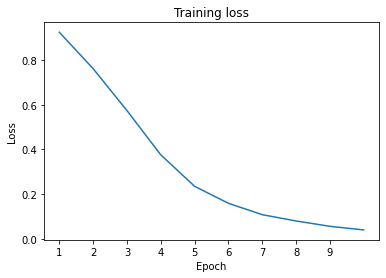

In [26]:
train_loss_set = training_phase(model, epochs, train_dataloader, optimizer, scheduler)
train_loss_plot(epochs, train_loss_set)

#### Testing phase

In [27]:
df_metrics = testing_phase(model, validation_dataloader)

#### Overall statistics and confusion matrix

In [28]:
print(classification_report(df_metrics['Actual_class'].values.astype(int), df_metrics['Predicted_class'].values.astype(int), digits=3))

              precision    recall  f1-score   support

           0      0.567     0.536     0.551       625
           1      0.692     0.724     0.708       947
           2      0.503     0.493     0.498       481

    accuracy                          0.613      2053
   macro avg      0.587     0.584     0.586      2053
weighted avg      0.610     0.613     0.611      2053



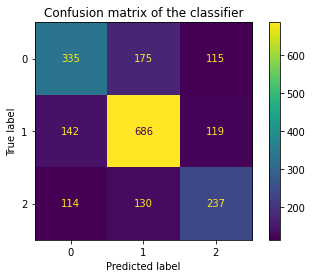

In [30]:
display_conf_matrix(df_metrics) # As a reminder, 'negative': 0 – 'neutral' : 1 – 'positive' : 2